In [15]:
import scipy.integrate
from classy import Class
from classy import CosmoComputationError
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
def class_compute(class_params):
    '''
    A function to handle CLASS computation and deal with potential errors.

    Args:
        :class_params (dict): Dictionary of CLASS parameters

    Returns:
        :cosmo (CLASS): Instance of the CLASS code
        :isNormal (bool): Whether error occurred in the computation
    '''
    cosmo = Class()
    cosmo.set(class_params)
    try:
        cosmo.compute()
        isNormal=True
    except CosmoComputationError as e:
        if "DeltaNeff < deltaN[0]" in str(e):
            # set YHe to 0.25. Value is from https://arxiv.org/abs/1503.08146 and Plank 2018(Section 7.6.1) https://arxiv.org/abs/1807.06209
            warnings.warn(f"Adjust YHe to 0.25 due to CLASS CosmoComputationError for cosmology {class_params}.")
            class_params['YHe'] = 0.25
            cosmo.set(class_params)
            cosmo.compute()
            isNormal=False
        else:
            raise e
    return cosmo, isNormal


def get_class_linear(k, As, Om, Ob, h, ns):
    """
    Compute linear P(k) using class for the cosmology of interest
    
    Args:
        :k (np.ndarray): k values to evaluate P(k) at [h / Mpc]
        :As (float): 10^9 times the amplitude of the primordial P(k)
        :Om (float): The z=0 total matter density parameter, Omega_m
        :Ob (float): The z=0 baryonic density parameter, Omega_b
        :h (float): Hubble constant, H0, divided by 100 km/s/Mpc
        :ns (float): Spectral tilt of primordial power spectrum
        
    Returns:
        :plin_class (np.ndarray): Linear power spectrum at corresponding k values [(Mpc/h)^3]
        :isNormal (bool): Whether error occurred in the computation
    """
    
    Oc =  Om - Ob
    redshift = 0.0
    
    class_params = {
        'h': h,
        'omega_b': Ob * h**2,
        'omega_cdm': Oc * h**2,
        'A_s': As*1.e-9,
        'n_s': ns,
        'output': 'mPk',
        'P_k_max_1/Mpc': k.max() * h,
        'w0_fld': -1,
        'wa_fld': 0,
        'Omega_Lambda': 0,  # Set to 0 because we're using w0_fld and wa_fld instead
        'tau_reio':0.0561,
        'z_max_pk': 3.0,  # Max redshift for P(k) output
    }
    
    cosmo, isNormal = class_compute(class_params)
    plin_class = np.array([cosmo.pk_lin(kk*h, redshift) for kk in k]) * h ** 3
    
    # Memory cleanup for class
    cosmo.struct_cleanup()
    cosmo.empty()

    return plin_class, isNormal


def get_sig(R, As, Om, Ob, h, ns):
    """
    Compute the bulk flow variance when the field is smoothed with a top
    hat filter of side length R.
    
    sigma^2 = H_0^2 f^2 / (2 \pi^2) \int_0^\infty dk W^2(k,R) P(k)
    
    where W(k,R) is the Fourier transform of the top hat filter
    
    Args:
        :k (np.ndarray): k values to evaluate P(k) at [h / Mpc]
        :As (float): 10^9 times the amplitude of the primordial P(k)
        :Om (float): The z=0 total matter density parameter, Omega_m
        :Ob (float): The z=0 baryonic density parameter, Omega_b
        :h (float): Hubble constant, H0, divided by 100 km/s/Mpc
        :ns (float): Spectral tilt of primordial power spectrum
        
    Returns:
        :sigma (float): Bulk flow RMS [km/s]
        
    """
    
    k = np.logspace(-4, 2, 300) # (h / Mpc)
    plin_class, isNormal = get_class_linear(k, As, Om, Ob, h, ns) # (Mpc/h)^3
    x = k * R
    integrand = plin_class * (3 * (np.sin(x) - x * np.cos(x)) / x ** 3) ** 2 # (Mpc/h)^3
    
    # Check units
    sigma = scipy.integrate.simpson(integrand, x=k) # (Mpc/h)^2
    H0 = 100 # h km/s/Mpc
    f = Om ** 0.55
    sigma = np.sqrt(sigma / 2) * H0 * f / np.pi # (Mpc/h) * h km/s/Mpc = km/s

    return sigma

100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


58.40857421174422


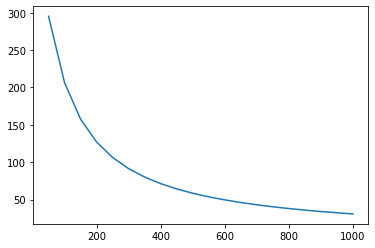

In [20]:
As = 2.105  # 10^9 A_s
h = 0.6766
Om = 0.3111
Ob = 0.02242 / h ** 2
ns = 0.9665

As = 1.7988  # 10^9 A_s
h = 0.68
Om = 0.335
Ob = 0.049
ns = 0.97

all_R = np.linspace(50, 1000, 20)
all_sigma = np.empty(len(all_R))

for i in tqdm(range(len(all_sigma))):
    all_sigma[i] = get_sig(all_R[i], As, Om, Ob, h, ns)
plt.plot(all_R, all_sigma)

print(get_sig(500, As, Om, Ob, h, ns))